In [1]:
import sys
import os 
sys.path.append("../../../libraries/pvae/")
from pvae.manifolds.poincareball import PoincareBall
from pvae.manifolds.euclidean import Euclidean
from pvae.models.architectures import EncWrapped, DecWrapped
from pvae.distributions.wrapped_normal import WrappedNormal
from pvae.distributions.riemannian_normal import RiemannianNormal
from pvae.ops.manifold_layers import GeodesicLayer
from pvae.objectives import vae_objective
from torch.distributions.normal import Normal
sys.path.append("../../../libraries/")
from HypHC.optim.radam import RAdam
from HypHC.utils.poincare import project
from HypHC.utils.visualization import plot_tree_from_leaves
from HypHC.utils.linkage import nn_merge_uf_fast_np, sl_from_embeddings
from HypHC.utils.metrics import dasgupta_cost
sys.path.append("../../hyperLAI")
import math
import torch
import torchvision
from torchvision import transforms
from torchvision.models import resnet18
from torch import nn
import torch.nn.functional as F
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
from models.hyperbolic_hc_loss import HyperbolicHCLoss
from models.encoder_decoder_architectures import *
from models.vae_model import vae_model
from torch.utils.data import SubsetRandomSampler, DataLoader, Subset
from torch.optim import Adam
from utils.sim_funcs import sim_func_dict
from utils.model_utils import *
from features.hyperLAIdataset import HyperLoader
from models.fc_model import fc_model



Define and play around with encoders and decoders

In [2]:
class resnet18_wrapped_encoder(nn.Module):
    def __init__(self, manifold, embedding_size, pretrained=True):
        super().__init__()
        self.manifold = manifold
        self.embedding_size = embedding_size
        self.resnet = resnet18(pretrained=pretrained, progress=False)
        self.resnet_chopped = torch.nn.Sequential(*(list(self.resnet.children())[:-1]))
        self.final_layer_mean = nn.Linear(512, self.embedding_size)
        self.final_layer_std = nn.Linear(512, self.embedding_size)
    def forward(self, images):
        img_features = self.resnet_chopped(images).flatten(start_dim=1)
        loc = self.final_layer_mean(img_features)
        loc = self.manifold.expmap0(loc)
        scale = nn.Softplus()(self.final_layer_std(img_features)) + 1e-5
        return loc, scale



In [3]:
class conv_wrapped_encoder(nn.Module):
    def __init__(self, manifold, input_length, embedding_size, num_int_layers, int_channels):
        super().__init__()
        self.manifold = manifold
        self.input_length = input_length
        self.embedding_size = embedding_size
        self.int_channels = int_channels
        self.conv_layers = nn.ModuleList()
        for layer in range(num_int_layers):
            self.conv_layers.append(nn.Sequential(
            nn.Conv2d(self.int_channels[layer],
                               self.int_channels[layer + 1],
                               kernel_size=3,
                               stride = 1,
                               padding=1),
            nn.BatchNorm2d(self.int_channels[layer+1]),
            nn.ReLU()))
        
        self.final_layer_mean = nn.Linear(self.int_channels[layer+1], self.embedding_size)
        self.final_layer_std = nn.Linear(self.int_channels[layer+1], self.embedding_size)
    def forward(self, images):
        for conv in self.conv_layers:
            images = conv(images)
        pooled_feats = nn.AvgPool2d(images.shape[-1])(images).squeeze()
        loc = self.final_layer_mean(pooled_feats)
        loc = self.manifold.expmap0(loc)
        scale = nn.Softplus()(self.final_layer_std(pooled_feats)) + 1e-5
        return loc, scale


In [4]:
class conv_wrapped_decoder(nn.Module):
    def __init__(self, manifold, input_length, embedding_size, num_int_layers, int_channels):
        super().__init__()
        self.manifold = manifold
        self.input_length = input_length
        self.embedding_size = embedding_size
        self.int_channels = int_channels
        self.emb_to_feature = nn.Linear(self.embedding_size, 4 * 4 * self.int_channels[0])
        self.conv_layers = nn.ModuleList()
        for layer in range(num_int_layers):
            self.conv_layers.append(nn.Sequential(
            nn.ConvTranspose2d(self.int_channels[layer],
                               self.int_channels[layer + 1],
                               kernel_size=3,
                               stride = 2,
                               padding=1,
                               output_padding=1),
            nn.BatchNorm2d(self.int_channels[layer+1]),
            nn.ReLU()))
        
        self.final_conv_layer = nn.ConvTranspose2d(self.int_channels[-1],
                               3,
                               kernel_size=3,
                               stride = 2,
                               padding=1,
                               output_padding=1
                                                  )
    def forward(self, embeddings):
        embeddings = self.manifold.logmap0(embeddings)
        recon_featmap = self.emb_to_feature(embeddings).view([-1, self.int_channels[0], 4, 4])
        for conv_trans in self.conv_layers:
            recon_featmap = conv_trans(recon_featmap)
        recon_data = nn.Sigmoid()(self.final_conv_layer(recon_featmap))
#         recon_data = F.interpolate(recon_data, size=(self.input_length, self.input_length))
        return recon_data


        

Loss and training functions (these will be moved to a .py file when development is done)

In [5]:
def compute_total_loss(model, device, embeddings, 
                       reconstructions, snp_data, labels, kl_weight, hc_weight, recon_weight, sim_func, qzx_fitted):
    #Calculate hierarchical clustering loss
    triple_ids, similarities = trips_and_sims(labels, sim_func)
    triple_ids = triple_ids.to(device)
    similarities = similarities.float().to(device)
    hyphc_loss = model.calculate_hyphc_loss(embeddings, triple_ids, similarities)
    #Calculate KL Divergence Loss
    pz_fitted = model.p_z(torch.zeros(1, embeddings.shape[-1]).to(device) + model.prior_mean, 
                   torch.zeros(1, embeddings.shape[-1]).to(device) + model.prior_std, model.manifold)
    if (model.qz_x, model.p_z) in torch.distributions.kl._KL_REGISTRY:
        kl_div = torch.distributions.kl_divergence(qzx_fitted, pz_fitted)
    else:
        kl_div = qzx_fitted.log_prob(embeddings.unsqueeze(dim=0)) - pz_fitted.log_prob(embeddings.unsqueeze(dim=0))
    kl_div = kl_div.sum(-1).mean()
    #Calculate NLL Loss of reconstruction
    mse = nn.MSELoss()
    mse_loss = mse(reconstructions, snp_data)
    total_loss = kl_weight * kl_div + hc_weight * hyphc_loss + recon_weight * mse_loss
    return total_loss, kl_weight * kl_div, hc_weight * hyphc_loss, recon_weight * mse_loss


In [6]:
def run_epoch(model, dloader, device, sim_func, kl_weight, hc_weight, recon_weight, optimizer=None):
    total_losses, kl_losses, hyphc_losses, reconstruction_losses = [], [], [], []
    for i, (image, label) in enumerate(dloader):
        if model.training:
            assert optimizer is not None
            optimizer.zero_grad()
        else:
            assert optimizer is None
        image = image.float().to(device)
        label = label.float().to(device)
        loc, scale, embeddings_pred, qzx_fitted, reconstructions = model(image)
        total, kl, hyphc, recon = compute_total_loss(model, device, embeddings_pred, reconstructions, 
                                                     image, label, kl_weight, hc_weight, recon_weight, sim_func, qzx_fitted)
        total_losses.append(total.item())
        kl_losses.append(kl.item())
        hyphc_losses.append(hyphc.item())
        reconstruction_losses.append(recon.item())
        if model.training:
            total.backward()
            optimizer.step()
    return np.nanmean(total_losses), np.nanmean(kl_losses), np.nanmean(hyphc_losses), np.nanmean(reconstruction_losses)

def train_model(model, train_loader, valid_loader, num_epochs, learning_rate, sim_func, kl_weight, hc_weight, recon_weight,
                txt_writer, output_dir, early_stopping, patience, early_stop_min_delta, optimizer=None):
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    if device == torch.device("cuda"):
        print("Training occurring on GPU")
        model = model.to(device)
    if optimizer is None:
        optimizer = RAdam(model.parameters(), lr=learning_rate)
    if early_stopping:
        valid_loss_history = []
    best_valid_epoch_loss, best_model = float("inf"), None
    for epoch in range(num_epochs):
        if device == torch.device("cuda"):
            torch.cuda.empty_cache()
        model.train()
        train_epoch_loss, train_kl_loss, train_hyphc_loss, train_recon_loss =\
        run_epoch(model, train_loader, device, sim_func, kl_weight, hc_weight, recon_weight, optimizer)
        print("Train: epoch %d: total loss = %6.10f, KL loss = %6.10f HC loss = %6.10f, reconstruction loss = %6.10f" %\
                      (epoch + 1, train_epoch_loss, train_kl_loss, train_hyphc_loss, train_recon_loss), txt_writer)
        with torch.no_grad():
            model.eval()
            valid_epoch_loss, valid_kl_loss, valid_hyphc_loss, valid_recon_loss =\
            run_epoch(model, valid_loader, device, sim_func, kl_weight, hc_weight, recon_weight, optimizer=None)
        print("Valid: epoch %d: total loss = %6.10f, KL loss = %6.10f, HC loss = %6.10f, reconstruction loss = %6.10f" %\
                      (epoch + 1, valid_epoch_loss, valid_kl_loss, valid_hyphc_loss, valid_recon_loss), txt_writer)
        if valid_epoch_loss < best_valid_epoch_loss:
            best_valid_epoch_loss = valid_epoch_loss
            best_model = model
#             save_model(model, optimizer, valid_epoch_loss, epoch + 1, output_dir+"model.pt")        
        if early_stopping:
            if len(valid_loss_history) < patience + 1:
                # Not enough history yet; tack on the loss
                valid_loss_history = [valid_epoch_loss] + valid_loss_history
            else:
                # Tack on the new validation loss, kicking off the old one
                valid_loss_history = \
                    [valid_epoch_loss] + valid_loss_history[:-1]
            if len(valid_loss_history) == patience + 1:
                # There is sufficient history to check for improvement
                best_delta = np.max(np.diff(valid_loss_history))
                if best_delta < early_stop_min_delta:
                    break  # Not improving enough
#         txt_writer.flush()

    return best_model

Prototype preprocessing

In [2]:
# cifar_transforms = transforms.Compose([
#     transforms.Resize(256),
#     transforms.CenterCrop(224),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])
cifar_transforms = transforms.Compose([
    transforms.ToTensor(),
])

In [3]:
cifar_train = torchvision.datasets.CIFAR100(root="/scratch/users/patelas/cifar100",train=True,download=False, transform=cifar_transforms)
cifar_test = torchvision.datasets.CIFAR100(root="/scratch/users/patelas/cifar100",train=False,download=False, transform=cifar_transforms)

In [4]:
# tv_final, others = torch.utils.data.random_split(cifar_train, [30000, 20000], generator=torch.Generator().manual_seed(0))
# train_final, valid_final = torch.utils.data.random_split(tv_final, [20000, 10000], generator=torch.Generator().manual_seed(0))

train_final, valid_final = torch.utils.data.random_split(cifar_train, [40000, 10000], generator=torch.Generator().manual_seed(0))
train_loader = DataLoader(train_final, batch_size=64)
valid_loader = DataLoader(valid_final, batch_size=64)

In [5]:
print(train_final[0][1], valid_final[0][1])

5 14


Train

In [10]:
manifold = PoincareBall(2)
encoder = conv_wrapped_encoder(manifold, 32, 2, 3, [3, 64, 64, 64])
decoder = conv_wrapped_decoder(manifold, 32, 2, 2, [64, 64, 64])
cifar_vae = vae_model(encoder, decoder, manifold, WrappedNormal,
                     WrappedNormal, 0.0, 1.0, 1e-4, 1e-3, 1e-2, 0.999)


In [12]:
model = train_model(cifar_vae, train_loader, valid_loader, 10, 1e-1, lambda x,y: int(x == y), 1, 1000, 100000, None, None, True, 7, 0.0)



Training occurring on GPU
Train: epoch 1: total loss = 5282.9821835938, KL loss = 4.5589526468 HC loss = 18.8989054222, reconstruction loss = 5259.5243304688 None
Valid: epoch 1: total loss = 4995.1726758435, KL loss = 4.8162865821, HC loss = 17.6042844505, reconstruction loss = 4972.7521132937 None
Train: epoch 2: total loss = 4952.7535406250, KL loss = 4.6509906097 HC loss = 18.6096028069, reconstruction loss = 4929.4929507813 None
Valid: epoch 2: total loss = 4906.7055741814, KL loss = 4.4959736463, HC loss = 17.4058302831, reconstruction loss = 4884.8037824691 None
Train: epoch 3: total loss = 4827.3633933594, KL loss = 4.7204322144 HC loss = 18.6510332970, reconstruction loss = 4803.9919292969 None
Valid: epoch 3: total loss = 4692.1686856215, KL loss = 4.8969226582, HC loss = 17.4374385093, reconstruction loss = 4669.8343093775 None
Train: epoch 4: total loss = 4605.1092738281, KL loss = 5.0887431999 HC loss = 18.6548994537, reconstruction loss = 4581.3656371094 None
Valid: epoch

In [13]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = model.to(device)
model.eval()
images, labels, embeddings, recons = [], [], [], []
with torch.no_grad():
    for i, (img, lab) in enumerate(valid_loader):
        embs = model.embed(img.float().to(device))
        images.append(img.cpu())
        embeddings.append(embs.cpu())
        labels.append(lab.cpu())
        recon = model.generate(embs.to(device))
        recons.append(recon.cpu())


In [14]:
images = torch.cat(images).numpy()
embeddings = torch.cat(embeddings).numpy()
labels = torch.cat(labels).numpy()
recons = torch.cat(recons).numpy()

Evaluate

In [15]:
def plot_weights_pca(embeddings, labels, annotations=None):
    '''
    Plot PCA of embedding
    '''
#     weights_pca = PCA().fit_transform(embeddings)
#     scplot = sns.scatterplot(x=weights_pca[:,0], y=weights_pca[:,1], hue=labels)
    scplot = sns.scatterplot(x=embeddings[:,0], y=embeddings[:,1], hue=[str(x) for x in labels])
#     plt.xlabel("PC1")
#     plt.ylabel("PC2")
#     plt.title("PCA of Embedding Weights")
    plt.xlabel("Embedding 1")
    plt.ylabel("Embedding 2")
    plt.title("Embedding Weights")

    if annotations is not None:
        for line in range(len(labels)):
#             if weights_pca[line,1] > -0.3:
#             if annotations[line] != "Hazara":
#                 continue
            scplot.text(embeddings[line,0]+0.001, embeddings[line,1], 
                         annotations[line], horizontalalignment='left', color='black', size=8)


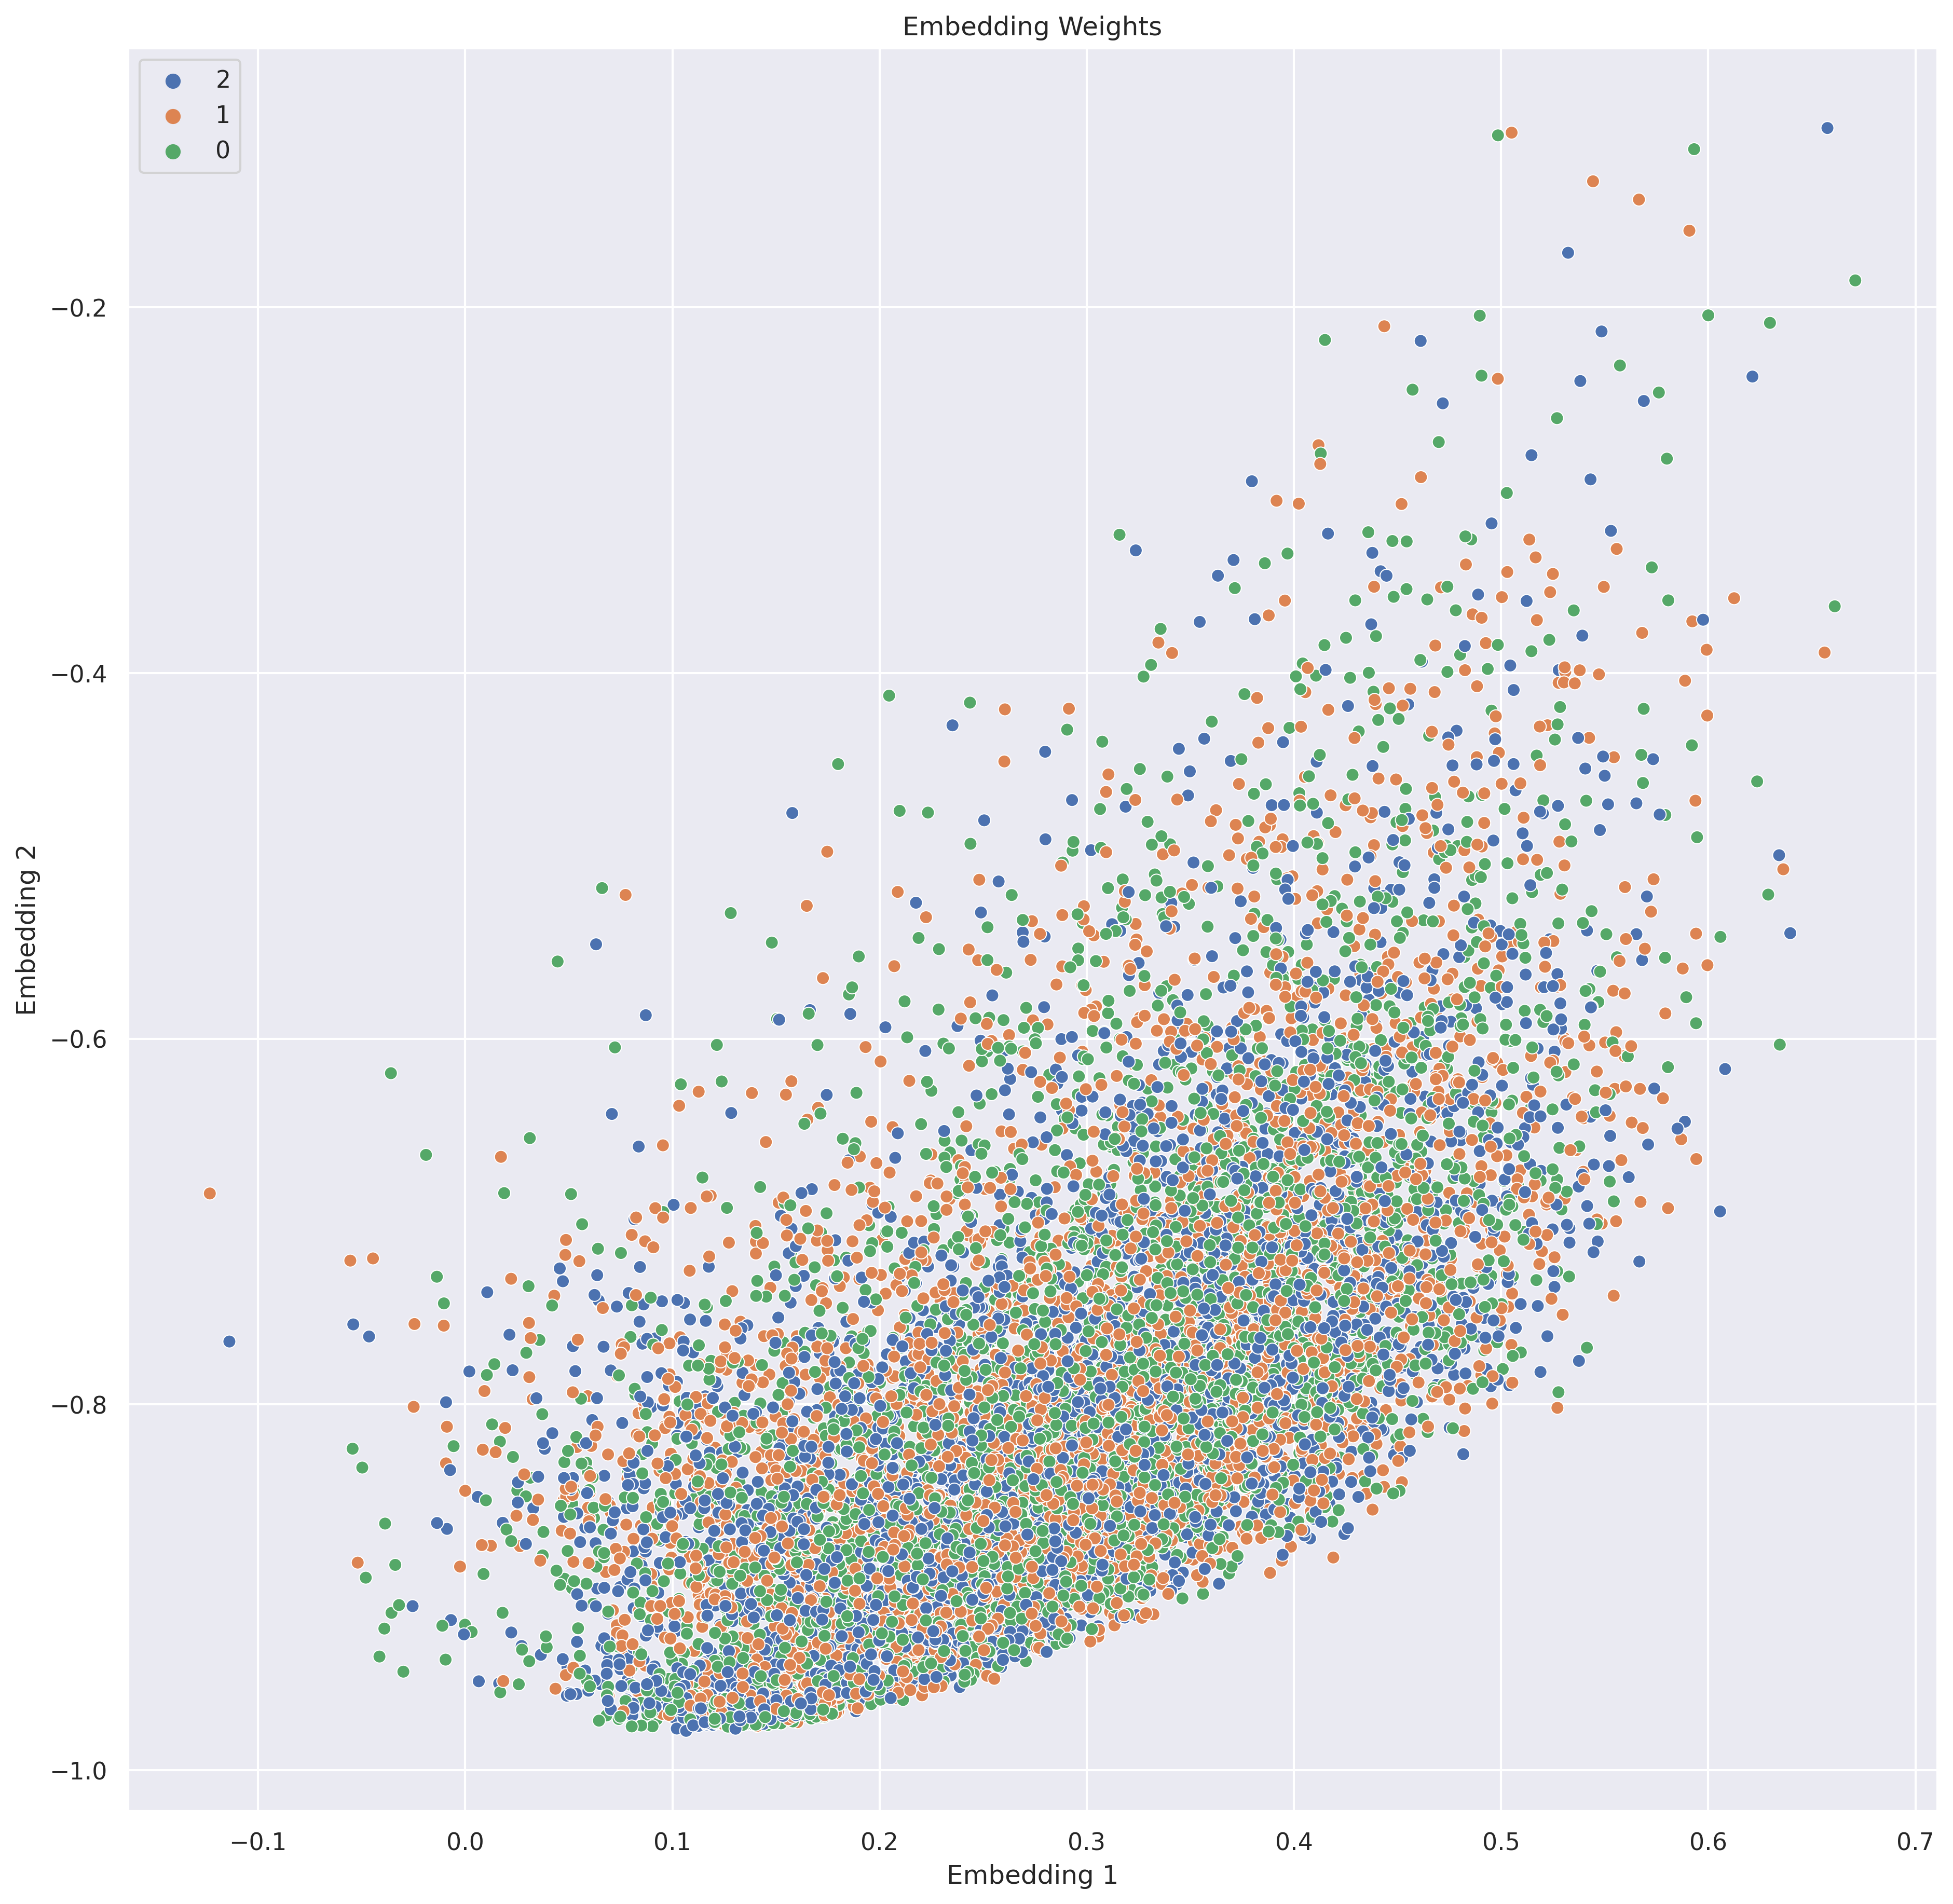

In [16]:
plt.figure(figsize=[15, 15], dpi=300)
plot_weights_pca(embeddings, labels % 3)
plt.show()

# View Reconstructions

In [17]:
def in_range(image):
    return (image - np.min(image)) / (np.max(image) - np.min(image))

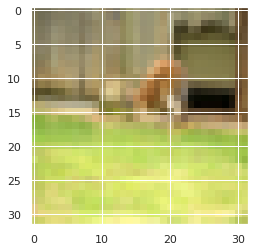

In [25]:
plt.imshow(in_range(images[134]).transpose([1,2,0]))
plt.show()

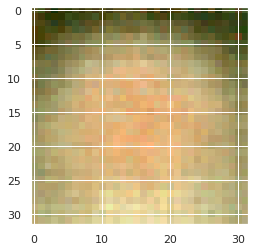

In [26]:
plt.imshow(in_range(recons[134]).transpose([1,2,0]))
plt.show()